Рустам Шамсутдинов БВТ2201

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, utils
import matplotlib.pyplot as plt
import numpy as np
import os

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.manual_seed(42)

batch_size = 128
lr = 1e-3
epochs = 50
hidden_sizes = [1024, 1024]
img_size = 28
D = img_size * img_size

In [3]:
transform = transforms.Compose([transforms.ToTensor()])
train_ds = datasets.MNIST(root="./data", train=True, download=True, transform=transform)
test_ds  = datasets.MNIST(root="./data", train=False, download=True, transform=transform)

def binarize_tensor(x):
    x = (x > 0.5).float()
    return x.view(x.size(0), -1)

class BinarizedMNIST(torch.utils.data.Dataset):
    def __init__(self, ds):
        self.data = ds.data.unsqueeze(1).float() / 255.0
        self.targets = ds.targets
    def __len__(self): return len(self.data)
    def __getitem__(self, idx):
        x = self.data[idx]
        x_bin = (x > 0.5).float()
        return x_bin.view(-1), self.targets[idx]

train = BinarizedMNIST(train_ds)
test  = BinarizedMNIST(test_ds)

train_loader = DataLoader(train, batch_size=batch_size, shuffle=True)
test_loader  = DataLoader(test,  batch_size=batch_size, shuffle=False)

In [ ]:
class MaskedLinear(nn.Linear):
    def __init__(self, in_features, out_features, bias=True):
        super().__init__(in_features, out_features, bias=bias)
        self.register_buffer('mask', torch.ones(out_features, in_features))

    def set_mask(self, mask):
        self.mask.data.copy_(mask)

    def forward(self, x):
        return F.linear(x, self.weight * self.mask, self.bias)

def create_masks(input_size, hidden_sizes, output_size, natural_order=True):
    rng = np.random.RandomState(42)
    L = [input_size] + hidden_sizes + [output_size]
    degrees = []
    degrees.append(np.arange(1, input_size+1))
    for h in hidden_sizes:
        degrees.append(rng.randint(1, input_size, size=h))
    degrees.append(np.tile(np.arange(1, input_size+1), int(output_size // input_size)))
    masks = []
    for l in range(len(L)-1):
        d_in = degrees[l]
        d_out = degrees[l+1]
        if l == 0:
            mask = (d_out[:, None] > d_in[None, :]).astype(np.float32)
        else:
            mask = (d_out[:, None] >= d_in[None, :]).astype(np.float32)
        masks.append(torch.from_numpy(mask))
    return masks

In [ ]:
class MADE(nn.Module):
    def __init__(self, input_size, hidden_sizes, use_residual=False):
        super().__init__()
        self.input_size = input_size
        self.hidden_sizes = hidden_sizes
        self.use_residual = use_residual

        hs = hidden_sizes
        in_sizes = [input_size] + hs
        out_sizes = hs + [input_size]
        self.net = nn.ModuleList()
        for m, n in zip(in_sizes, out_sizes):
            self.net.append(MaskedLinear(m, n))
        self.activation = nn.ReLU()
        self.masks = None
        self.create_and_set_masks()

    def create_and_set_masks(self):
        masks = create_masks(self.input_size, self.hidden_sizes, self.input_size)
        assert len(masks) == len(self.net)
        for layer, mask in zip(self.net, masks):
            layer.set_mask(mask.to(layer.weight.device))
        self.masks = masks

    def forward(self, x):
        h = x
        for i, layer in enumerate(self.net):
            h = layer(h)
            if i < len(self.net)-1:
                h = self.activation(h)
        return h

In [6]:
model = MADE(input_size=D, hidden_sizes=hidden_sizes).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
bce_loss = nn.BCEWithLogitsLoss(reduction='mean')

def train_epoch(epoch):
    model.train()
    total_loss = 0.0
    for xb, _ in train_loader:
        xb = xb.to(device)
        logits = model(xb)
        loss = bce_loss(logits, xb)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * xb.size(0)
    avg = total_loss / len(train)
    print(f"[Train] Epoch {epoch} avg loss per example: {avg:.6f}")

def eval_epoch(epoch):
    model.eval()
    tot = 0.0
    with torch.no_grad():
        for xb, _ in test_loader:
            xb = xb.to(device)
            logits = model(xb)
            loss = bce_loss(logits, xb)
            tot += loss.item() * xb.size(0)
    print(f"[Eval]  Epoch {epoch} avg loss per example: {tot/len(test):.6f}")

for epoch in range(1, epochs+1):
    train_epoch(epoch)
    eval_epoch(epoch)

[Train] Epoch 1 avg loss per example: 0.246374
[Eval]  Epoch 1 avg loss per example: 0.172517
[Train] Epoch 2 avg loss per example: 0.153685
[Eval]  Epoch 2 avg loss per example: 0.138654
[Train] Epoch 3 avg loss per example: 0.133059
[Eval]  Epoch 3 avg loss per example: 0.126705
[Train] Epoch 4 avg loss per example: 0.123845
[Eval]  Epoch 4 avg loss per example: 0.120190
[Train] Epoch 5 avg loss per example: 0.118185
[Eval]  Epoch 5 avg loss per example: 0.115880
[Train] Epoch 6 avg loss per example: 0.114133
[Eval]  Epoch 6 avg loss per example: 0.112803
[Train] Epoch 7 avg loss per example: 0.111098
[Eval]  Epoch 7 avg loss per example: 0.110706
[Train] Epoch 8 avg loss per example: 0.108792
[Eval]  Epoch 8 avg loss per example: 0.109077
[Train] Epoch 9 avg loss per example: 0.106990
[Eval]  Epoch 9 avg loss per example: 0.107935
[Train] Epoch 10 avg loss per example: 0.105316
[Eval]  Epoch 10 avg loss per example: 0.106803
[Train] Epoch 11 avg loss per example: 0.103861
[Eval]  Ep

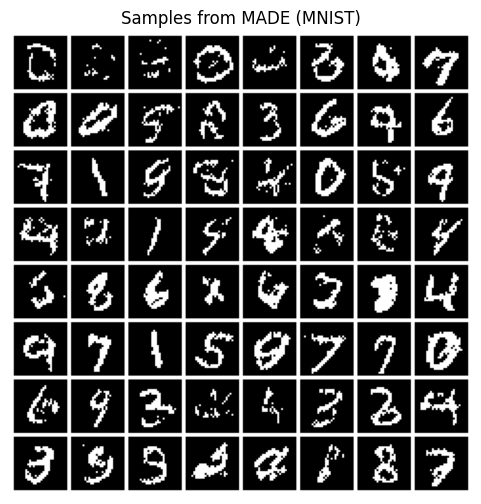

In [7]:
@torch.no_grad()
def sample_made(model, n_samples=64, device=device):
    model.eval()
    x = torch.zeros(n_samples, D, device=device)
    for i in range(D):
        logits = model(x)
        probs = torch.sigmoid(logits[:, i])
        sample_i = torch.bernoulli(probs)
        x[:, i] = sample_i
    return x.view(n_samples, 1, img_size, img_size)

samples = sample_made(model, n_samples=64)
grid = utils.make_grid(samples.cpu(), nrow=8, pad_value=1.0)
plt.figure(figsize=(6,6))
plt.axis('off')
plt.imshow(grid.permute(1,2,0).squeeze(), cmap='gray')
plt.title("Samples from MADE (MNIST)")
plt.show()